In [7]:
# Copyright 2017 Department of Electrical and Computer Engineering, Cornell University. All rights reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

This is a package for locally private data transmission. 

In [198]:
%matplotlib inline
import math
import numpy as np
import random
import matplotlib.pyplot as plt
#the Hadamard randamized responce when \epsilon < 1

# def FWHT(X):
#     # Fast Walsh-Hadamard Transform for 1D signals
#     # of length n=2^M only (non error-proof for now)
#     x = X[::-1]
#     x=np.array(x)
#     N=len(X)
 
#     for i in range(0,N,2):
#         x[i]=x[i]+x[i+1]
#         x[i+1]=x[i]-2*x[i+1]
 
#     L=1
#     y=np.zeros_like(x)
#     for n in range(2,int(math.log(N,2))+1):
#         M=2**L
#         J=0; K=0
#         while(K<N):
#             for j in range(J,J+M,2):
#                 y[K]   = x[j]   + x[j+M]
#                 y[K+1] = x[j]   - x[j+M]
#                 y[K+2] = x[j+1] + x[j+1+M]
#                 y[K+3] = x[j+1] - x[j+1+M]
#                 K=K+4
#             J=J+2*M
#         x=y.copy()
#         L=L+1
 
#     return -x

# def SFWHT(X):
#     """ 'Slower' Fast Walsh-Hadamard Transform
#     Step#1 Get sequency-ordered input
#     Step#2 Perform Hadamard Transform
#     """
#     x=get_sequency_list(X)
#     N = x.size
#     M = int(log(N,2))
#     out = x.copy()
#     for m in xrange(M):
#         outtemp = out.copy()         
#         step = 2**m
#         numCalc = 2**m
#         for g in xrange(0,N,2*step): # number of groups
#             for c in xrange(numCalc):
#                 index = g + c
#                 out[index] = outtemp[index] + outtemp[index+step]
#                 out[index+step] = outtemp[index] - outtemp[index+step]
#     return out/float(N)

def FWHT_A(k, dist):
    if k == 1:
        return dist
    dist1 = dist[0 : k/2]
    dist2 = dist[k/2 : k]
    trans1 = FWHT_A(k/2, dist1)
    trans2 = FWHT_A(k/2, dist2)
    trans = np.concatenate((trans1+ trans2, trans1 - trans2))
    return trans

class Hadamard_Rand_1:
    def __init__(self, absz, pri_para): # absz: alphabet size, pri_para: privacy parameter
        self.insz = absz #input alphabet size k
        self.outsz = int(math.pow(2,math.ceil(math.log(absz+1,2)))) #output alphabet size: smallest exponent of 2 which is bigger than k
        self.outbit = int(math.ceil(math.log(absz+1,2))) #output bit length
        self.exp = math.exp(pri_para) #privacy parameter
        self.pri_para = 1/(1+math.exp(pri_para)) #flipping probability to maintain local privacy

    def parity_check(self,x,y): #check if the hadamard entry is one (return 0 for if the entry is 1)
        z = x&y #bit and
        z_bit = bin(z)[2:].zfill(self.outbit)
        check = 0
        for i in range(0,self.outbit): #check = \sum_i (x_i y_i) （mod 2）
            check = check^int(z_bit[i]) 
        return check
                                  
    def encode_symbol(self,ori):  # encode a single symbol into a privatized version
        bitin = bin(int(ori)+1)[2:].zfill(self.outbit) #map the input symbol x to x+1 since we are not using the first column of the matrix
        out1 = random.randint(0,math.pow(2,self.outbit)-1) #get a random number in the output alphabet as one potential output
        bitout1 = bin(out1)[2:].zfill(self.outbit)
        for i in range(0,self.outbit): #flip the bit of out1 corresponding to the left most bit in (ori+1) which is one to get the other potential output
            if int(bitin[i]) == 1:
                out2 = out1 ^ (pow(2,self.outbit - i -1))
                break   
        #bitout2 = bin(out2)[2:].zfill(self.outbit)
        check = 0
        for i in range(0,self.outbit): # check if the Hadamard entry at position (ori+1, out1) is one or not
            check = check^(int(bitout1[i])&int(bitin[i]))
        ra = random.random()
        if check == 0: # if it is one output out1 with prob (1-pri_para)
            if ra > self.pri_para:
                return out1
            else:
                return out2
        else: # else output out2 with prob (1-pri_para)
            if ra > self.pri_para:
                return out2
            else:
                return out1       
     
    def encode_string(self,in_list):  # encode string into a privatized string
        out_list = [self.encode_symbol(x) for x in in_list] # encode each symbol in the string
        return out_list
    
    def decode_string2(self, out_list): # get the privatized string and learn the original distribution
        l = len(out_list) 
#        num = [0]*self.insz
#         count = [0]*self.outsz
#         for x in out_list: # count the number of appearances of each output symbol
#             count[x] = count[x] + 1 
        count,edges = np.histogram(out_list,range(self.outsz+1))
#         for x in range(0,self.outsz):
#             #print x
#             for i in range(1, self.insz+1): #if output x is in C_i(locations in row i which is 1), add it to the count of C_i
#                 if self.parity_check(i,x) == 0:
#                     num[i-1] = num[i-1] + count[x]
        dist = count/float(l)
        dist_mid = FWHT_A(self.outsz, dist)
        #dist_mid = FWHT(dist)
        dist_S = (dist_mid[1:self.insz+1] + 1)/float(2)
#        dist_S = [float(x)/float(l) for x in num] #get the frequencies of C_i
        dist = (2*dist_S*(1+self.exp)-(1+self.exp))/float(self.exp-1) #calculate the corresponding estimate for p_i
        dist = np.maximum(dist,0) #map it to be positive
        norm = np.sum(dist)
        dist = dist/float(norm) #ensure the l_1 norm is one
        return dist
    
    def decode_string(self, out_list): # get the privatized string and learn the original distribution
        l = len(out_list) 
        num = [0]*self.insz
        count = [0]*self.outsz
        for x in out_list: # count the number of appearances of each output symbol
            count[x] = count[x] + 1 
        
        for x in range(0,self.outsz):
            #print x
            for i in range(1, self.insz+1): #if output x is in C_i(locations in row i which is 1), add it to the count of C_i
                if self.parity_check(i,x) == 0:
                    num[i-1] = num[i-1] + count[x]
        dist_S = [float(x)/float(l) for x in num] #get the frequencies of C_i
        dist = [(2*x*(1+self.exp)-(1+self.exp))/(self.exp-1) for x in dist_S] #calculate the corresponding estimate for p_i
        dist = [max(x,0) for x in dist] #map it to be positive
        norm = sum(dist)
        dist = [x/norm for x in dist] #ensure the l_1 norm is one
        return dist

In [219]:
#The Hadamard randomized response for all regimes

class Hadamard_Rand_2:
    def __init__(self, absz, pri_para): # absz: alphabet size, pri_para: privacy parameter
        self.insz = absz #input alphabet size k
        #self.outsz = int(math.pow(2,math.ceil(math.log(absz+1,2)))) #output alphabet size: smallest exponent of 2 which is bigger than k
        #self.outbit = int(math.ceil(math.log(absz+1,2))) #output bit length
        self.pri_para = 1/(1+math.exp(pri_para)) #flipping probability to maintain local privacy
        self.exp = math.exp(pri_para) #privacy parameter
        self.initbit = int(math.floor(math.log(self.exp,2))) # number of bits indicating the block number 
        self.part = int(math.pow(2,self.initbit)) #number of blocks B
        self.tailbit = int(math.ceil(math.log(float(self.insz)/float(self.part)+1,2))) #number of bits indicating the location within a block
        self.partsz = int(math.pow(2,self.tailbit)) # size of each block b
        self.outbit = self.tailbit + self.initbit #total number of output bits
        self.outsz = int(math.pow(2,self.outbit)) # output alphabet size K

    def entry_check(self,x,y): #check if the reduced hadamard entry is one (return 0 for 1)
        x_bit = bin(x)[2:].zfill(self.outbit)
        y_bit = bin(y)[2:].zfill(self.outbit)
        for i in range(0,self.initbit): # check if they are in the same block, if not, return -1
            if x_bit[i] != y_bit[i]:
                return True
        check = False
        for i in range(self.initbit, self.outbit): #check whether the entry is one within the block
            check = check^(int(x_bit[i]) & int(y_bit[i]))
        return check
                                  
    def encode_symbol(self,ori):  # encode a single symbol into a privatized version 
        # we use coupling argument to do this
        ori1 = int(ori)//(self.partsz-1)*self.partsz + int(ori)%(self.partsz-1)+1 #map the input x to the xth column with weight b/2 
        bitin = bin(int(ori1))[2:].zfill(self.outbit)
        out1 = random.randint(0,self.outsz-1) #get a random number out1 in the output alphabet as a potential output
        ra = random.random()
        if ra < (2*self.part)/(2*self.part-1+self.exp): #with certain prob, output the same symbol as from uniform distribution
            return out1
        else:
            out1 = out1%self.partsz + self.partsz*(ori1//self.partsz) # map out1 to the same block as ori1 while maintain the location within the block
            if self.entry_check(ori1,out1) == 0: #if location (ori1, out1) is one, output out1
                return out1
            else: #else flip bit at the left most location where bit representation of ori1 is one 
                for i in range(self.initbit, self.outbit): 
                    if int(bitin[i]) == 1:
                        out1 = out1 ^ (pow(2,self.outbit - i -1))
                        break
                return out1
     
    def encode_string(self,in_list):  # encode string into a privatized string
        out_list = [self.encode_symbol(x) for x in in_list]
        return out_list
    
    def decode_string(self, out_list): # get the privatized string and learn the original distribution
#         l = len(out_list)
#         num = [0]*self.insz
#         count,edges = np.histogram(out_list,range(self.outsz+1))
            
#         count_block = [0]*self.part # count the number of appearances of each block
#         for i in range(0,self.part): 
#             #count_block[i] = sum(count[i*self.partsz : (i+1)*self.partsz - 1])
#              for j in range(0,self.partsz):
#                  count_block[i] = count_block[i] + count[i*self.partsz+j]
        
#         freq_block = [float(x)/float(l) for x in count_block] # calculate the frequency of each block
#         dist_block = [((2*self.part-1+self.exp)*x-2)/(self.exp-1) for x in freq_block] # calculate the estimated original prob of each block
        
#         for x in range(0,self.outsz): # count the number of appearances of each C_i
#             #print x
#             for i in range(0, self.insz): 
#                 ti = int(i)//(self.partsz-1)*self.partsz + int(i)%(self.partsz-1)+1
#                 if self.entry_check(ti,x) == 0:
#                     num[i] = num[i] + count[x]
#         dist_S = [float(x)/float(l) for x in num] #calculate the frequency of each C_i
#         dist_inter = [2*(x*(2*self.part-1+self.exp)-1)/(self.exp-1) for x in dist_S] # calculate intermediate prob
#         dist = [dist_inter[i] - dist_block[i//(self.partsz-1)] for i in range(0,self.insz)] # calculate the estimated prob for each symbol
#         dist = [max(x,0) for x in dist] #map it to be positive
#         norm = sum(dist)
#         dist = [x/norm for x in dist] #ensure the l_1 norm is one
        
        l = len(out_list)
        dist_S = np.zeros(self.insz)
        count,edges = np.histogram(out_list,range(self.outsz+1))
        freq = count/float(l)
        
        freq_block = np.zeros(self.part) # count the number of appearances of each block
        for i in range(0,self.part): 
            #count_block[i] = np.sum(count[i*self.partsz : (i+1)*self.partsz - 1])
            for j in range(0,self.partsz):
                freq_block[i] = freq_block[i] + freq[i*self.partsz+j]
        
#         count_block = np.zeros(self.part) # count the number of appearances of each block
#         for i in range(0,self.part): 
#             #count_block[i] = np.sum(count[i*self.partsz : (i+1)*self.partsz - 1])
#             for j in range(0,self.partsz):
#                 count_block[i] = count_block[i] + count[i*self.partsz+j]
        
        #freq_block = np.true_divide(count_block,l) # calculate the frequency of each block
        dist_block = np.true_divide((2*self.part-1+self.exp)*(freq_block)-2,self.exp-1) # calculate the estimated original prob of each block
        
#         for x in range(0,self.outsz): # count the number of appearances of each C_i
#             #print x
#             for i in range(0, self.insz): 
#                 ti = int(i)//(self.partsz-1)*self.partsz + int(i)%(self.partsz-1)+1
#                 if self.entry_check(ti,x) == 0:
#                     num[i] = num[i] + count[x]

#         parts = self.insz//(self.partsz-1)            
#         for i in range(0, parts):
#             for j in range(0,self.partsz-1):
#                 x = i*(self.partsz-1) + j
#                 x_i = i*self.partsz + j + 1
#                 for k in range(0,self.partsz):
#                     y_i = i*self.partsz + k
#                     if self.entry_check(x_i,y_i) == 0:
#                         dist_S[x] = dist_S[x] + freq[y_i]
                        
#         for j in range(0, self.insz - parts*(self.partsz-1)):
#             x = parts*(self.partsz-1) + j
#             x_i = parts*self.partsz + j + 1
#             for k in range(0,self.partsz):
#                 y_i = parts*self.partsz + k
#                 if self.entry_check(x_i,y_i) == 0:
#                     dist_S[x] = dist_S[x] + freq[y_i]
                    
        for i in range(0, self.insz): 
            pi = int(i)//(self.partsz-1)
            ti = pi*self.partsz + int(i)%(self.partsz-1)+1
            for x in range(pi*self.partsz, (pi+1)*self.partsz): # count the number of appearances of each C_i
                if self.entry_check(ti,x) == 0:
                    dist_S[i] = dist_S[i] + freq[x]

#        dist_S = np.zeros(self.insz)
        #dist_S = np.true_divide(num,l) #calculate the frequency of each C_i
        dist_inter = np.true_divide(2*(dist_S*(2*self.part-1+self.exp)-1),self.exp-1) # calculate intermediate prob
        dist = [dist_inter[i] - dist_block[i//(self.partsz-1)] for i in range(0,self.insz)] # calculate the estimated prob for each symbol
        dist = np.maximum(dist,0) #map it to be positive
        norm = np.sum(dist)
        dist = np.true_divide(dist,norm) #ensure the l_1 norm is one
        return dist
    
    
    def decode_string2(self, out_list): # get the privatized string and learn the original distribution
        
        l = len(out_list)
        count,edges = np.histogram(out_list,range(self.outsz+1))
        freq = count/float(l)
        
        parts = self.insz//(self.partsz-1) 
        freq_S = np.zeros((parts+1)*self.partsz)
        freq_block = np.zeros((parts+1)*self.partsz)
        
        for i in range(0, parts+1):
            Trans = FWHT_A(self.partsz, freq[i*self.partsz: (i+1)*self.partsz])
            freq_block[i] = Trans[0]
            freq_S[i*(self.partsz-1): (i+1)*(self.partsz-1)] = (Trans[1:self.partsz] + Trans[0])/float(2) 
        dist_S = freq_S[0:self.insz]
        
        #freq_block = np.true_divide(count_block,l) # calculate the frequency of each block
        dist_block = np.true_divide((2*self.part-1+self.exp)*(freq_block)-2,self.exp-1) # calculate the estimated original prob of each block
        
                    
#         for i in range(0, self.insz): 
#             pi = int(i)//(self.partsz-1)
#             ti = pi*self.partsz + int(i)%(self.partsz-1)+1
#             for x in range(pi*self.partsz, (pi+1)*self.partsz): # count the number of appearances of each C_i
#                 if self.entry_check(ti,x) == 0:
#                     dist_S[i] = dist_S[i] + freq[x]

        
        
        #dist_S = np.true_divide(num,l) #calculate the frequency of each C_i
        dist_inter = np.true_divide(2*(dist_S*(2*self.part-1+self.exp)-1),self.exp-1) # calculate intermediate prob
        dist = [dist_inter[i] - dist_block[i//(self.partsz-1)] for i in range(0,self.insz)] # calculate the estimated prob for each symbol
        dist = np.maximum(dist,0) #map it to be positive
        norm = np.sum(dist)
        dist = np.true_divide(dist,norm) #ensure the l_1 norm is one
        return dist

128
7
('l1 distance: ', '0.153261824741')
('prob_sum: ', '1.0')


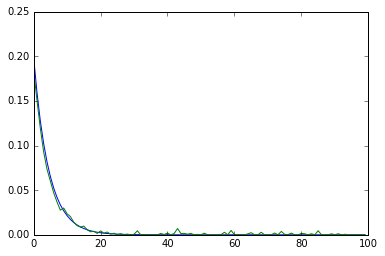

In [221]:
if __name__ == "__main__":
    k = 100 #absz
    elements = range(0,k) #ab
    lbd = 0.8 #parameter for geometric dist
    eps = 1 # privacy_para
    prob = [(1-lbd)*math.pow(lbd,x)/(1-math.pow(lbd,k)) for x in elements] # geometric dist
    #prob = [1/float(k)] * k
    in_list = np.random.choice(elements, 1000000, p=prob) #input symbols
    a = Hadamard_Rand_2(k,eps) 
    print(a.outsz)
    print(a.outbit)
    #print (a.partsz)
    #print (elements.type)
    # print(type(in_list[9]))
    outp = a.encode_string(in_list)
    #print outp
    prob_est = a.decode_string2(outp) # estimate the original underlying distribution
    plt.plot(elements,prob)
    plt.plot(elements,prob_est)
    #plt.plot(prob_est)
    print ("l1 distance: ", str(np.linalg.norm([a_i - b_i for a_i, b_i in zip(prob, prob_est)], ord=1)))
    print ("prob_sum: ", str(sum(prob_est)))

In [215]:
a = np.arange(5)
print a
b = np.zeros(10)
print b
a[2:4] = b[1:3]
print a
a = (a + b[0])/float(2)
print a

[0 1 2 3 4]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
[0 1 0 0 4]
[ 0.   0.5  0.   0.   2. ]


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
l1 distance0.540320855615
prob_sum1.0


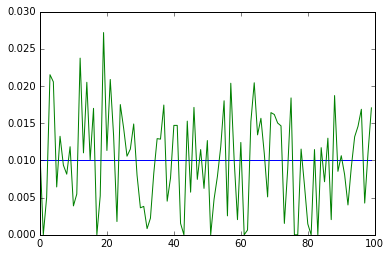

In [222]:
if __name__ == "__main__":
    import timeit
    k = 100 #absz
    elements = range(0,k) #ab
    lbd = 0.8 #parameter for geometric dist
    eps = 1 # privacy_para
    #prob = [(1-lbd)*math.pow(lbd,x)/(1-math.pow(lbd,k)) for x in elements] # geometric dist
    prob = [1/float(k)] * k
    in_list = np.random.choice(elements, 100000, p=prob) #input symbols
    a = Hadamard_Rand_2(k,eps) # define the private channel
    t1 = 0
    t2 = 0
    for i in range(1,51):
        print(i)
        start_time = timeit.default_timer()
        outp = a.encode_string(in_list) # get the output string
        t1 = t1 + timeit.default_timer() - start_time
        start_time = timeit.default_timer()
        prob_est = a.decode_string2(outp) # estimate the original underlining distribution
        t2 = t2 + timeit.default_timer() - start_time
    plt.plot(elements,prob)
    plt.plot(elements,prob_est)
    print 'l1 distance' + str(np.linalg.norm([a_i - b_i for a_i, b_i in zip(prob, prob_est)], ord=1))
    print 'prob_sum' + str(sum(prob_est))

In [3]:
# k = 100 #absz
# elements = range(0,k) #ab
# lbd = 0.8 #parameter for geometric dist
# eps = 1 # privacy_para
# #prob = [(1-lbd)*math.pow(lbd,x)/(1-math.pow(lbd,k)) for x in elements] # geometric dist
# prob = [1/float(k)] * k
# #in_list = np.random.choice(elements, 100000, p=prob) #input symbols
# n = 1
# in_list = [n]*100000
# outp = a.encode_string(in_list)
# count = [0]*a.outsz
# for x in outp:
#     count[x] = count[x] + 1
# plt.plot(count)

# a = Hadamard_Rand_2(k,eps) 
# x = random.randint(0,a.outsz-1)
# y = random.randint(0,a.outsz-1)
# x_bit = bin(int(x))[2:].zfill(a.outbit)
# y_bit = bin(int(y))[2:].zfill(a.outbit)
# print (a.initbit)
# print (a.tailbit)
# print ('x:' + x_bit)
# print ('y:' + y_bit)
# print (a.entry_check(x,y))
# print (a.partsz)
# print (int(n)/(a.partsz-1)*a.partsz + int(n)%(a.partsz-1)+1)